<div class="usecase-title">Analysis of Feature Importance of variables on Bin Fill Levels at Argyle Square</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>
<div class="usecase-duration"><b>Duration: </b>90 mins</div>
<div class="usecase-level"><b>Level: </b>Intermediate</div>
<div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>

<div class="usecase-section-header">Scenario</div>

 
1. I am planning an event at Argyle Square and need to know if there will be sufficient waste collection space in the bins, so need to know what conditions cause bin fill level to be higher.

2. I am a waste collection planner and need to know what conditions may cause bins to be at a fuller level.

<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Filtering of dataframes
- Use of date time to resample data by different time increments
- Create box plots from a dataframe to view datasets
- Create scatterplots from a dataframe to identify variable relationships
- Create pairplots from a dataframe to identify variable relationships
- Use Pearson correlation heatmap to identify linear variable relationships
- Use distance calculation to identify non-linear variable relationships
- Linear regression for predictive analysis
- Random Forest for predictive analysis
- Calculate feature importance, r-squared value and accuracy from predictive analysis

<div class="usecase-section-header">Why do we need to predict bin fill levels?</div>

Prediction of bin fill levels can assist in solving two problems, that of issues relating to overflowing bins and that of rising costs to council for waste collection. If bin fill can be predicted, bins can be emptied in a timely manner,  ensuring there is space for new waste generated and reducing waste collection costs.</br>
Overflowing waste is a growing problem in modern cities. When bins overflow, it causes a liturgy of problems. These include streets cluttered with rubbish that cannot be placed in bins; rubbish washing into storm water drainage causing water pollution and an increase in bacteria, insects and vermin which cause health risks to humans <a href="#fn-1">[1]</a>. These factors also contrinute to a reduction in the wellbeing of inhabitants.</br>
In waste collection services, the main cost is in the distrance travelled by a truck to collect rubbish <a href="#fn-2">[2]</a>. In the situation where a container is known to be not full and predicted to have little rubbish added, the bin need not be collected. This means that the bin can be taken off the truck's route, reducing the distance travelled by the truck and thus saving costs in fuel, time and long term truck maintinence.
 



<div class="usecase-section-header">Relevant Datasets</div>

[Blix Visits](https://data.melbourne.vic.gov.au/explore/dataset/blix-visits/information/)

- The Blix Visits data uses mobile phone counting <a href="#fn-3">[3]</a> to count the number of phones in a location. This dataset reports data at 3 minute intervals for each sensor; including a total count, dwell time and average dwell time (in minutes) of individual mobile phones. The blix sensors at Argle Square are the only ones of interest, so the data will be filtered at venueId 7780, Argyle Square. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Argyle Square Sound Stage Activity](https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-3/information/)
- The sound stage at Argyle Park has been fitted with three Elsys sensors <a href="#fn-3">[3]</a> to monotor movement on the stage. This data is reported every 3 minutes and includes an interger measurement value of motion and visit. In addition, the sensors also measure and report environmental data of temperature, humidity and light. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Netvox R718X Bin Sensor](https://data.melbourne.vic.gov.au/explore/dataset/netvox-r718x-bin-sensor/information/?disjunctive.dev_id)
- Netvox R718X measures distance using an ultrasonic ranging <a href="#fn-3">[3]</a>, which is used to calculate the bin fill level reported in the bin sensor data set. These levels are recorded every 15 minutes. This dataset aso reports the senros name, location and timedate data for the reading. Temperature and battery level are also recorded but not used in this use case. There are many bins across Argyle Square using this technology, but only bins from the area adjactent to the sound stage have been included in this investigation. This dataset is imported from the Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

### REQUIRED MODULES

In [1]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

# Import required modules
import requests
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
from sklearn import datasets
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import statistics

### IMPORT DATASETS

Import datasets using API v2.1 GET request with /exports/

In [2]:
from io import StringIO

# Function to collect datasets using API
def datasetcollect(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = " "
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [4]:
# Import stage activity dataset
dataset_id = 'meshed-sensor-type-3'
stage_activity_all = datasetcollect(dataset_id)
print(len(stage_activity_all))
stage_activity_all.head(3)

381554


,dev_id,sensor_name,time,temperature,humidity,light,motion,visit,vdd,lat_long
0,ers-55eb,NaN,2022-12-13T20:09:42+00:00,10.5,89,297,0,0,3638,NaN
1,ers-55ea,NaN,2022-12-13T20:26:03+00:00,10.6,88,136,0,0,3635,NaN
2,ers-55eb,NaN,2022-12-13T20:34:47+00:00,10.8,89,698,0,0,3638,NaN


In [5]:
# Import bin sensor dataset
dataset_id = 'netvox-r718x-bin-sensor'
bin_sensor_all = datasetcollect(dataset_id)
print(len(bin_sensor_all))
bin_sensor_all.head(3)

599463


,dev_id,time,temperature,distance,filllevel,battery,lat_long,sensor_name,fill_level
0,r718x-6778,2023-02-26T08:16:47+00:00,19.0,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
1,r718x-6f16,2023-02-26T08:18:10+00:00,19.9,202.0,74.0,3.6,"-37.8028794, 144.9662728",r718x-bin sensor 17,72.0
2,r718x-677d,2023-02-26T08:18:02+00:00,20.7,200.0,74.0,3.6,"-37.8021051, 144.9654523",r718x-bin sensor 11,72.0


In [6]:
# Import blix mobile phone counter dataset
dataset_id = 'blix-visits'
blix_phones_all = datasetcollect(dataset_id)
print(len(blix_phones_all))
blix_phones_all.head(3)

115218


,datetime,keys1,total,dwell,sensor_name,sensor_type,lat_long,avg_dwell
0,2022-08-25T22:00:00+00:00,8171,27,5697,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",3.0
1,2022-08-26T08:00:00+00:00,8171,115,42090,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",6.0
2,2022-08-26T02:00:00+00:00,7780,228,94848,Pedestrian Sensor-Argyle Sq,Mobile phone counting,"-37.8025805, 144.9656012",6.0


### DATA PREPPROCESSING

Preprocessing of datasets involves deleting unwanted columns, converting data types, resampling withing common dateframes, filtering rows in datasets by variables, resmapling using date time.

In [7]:
# Delete unwanted columns from datasets

# Drop columns from stage_activity dataframe
stage_activity = stage_activity_all[['dev_id','time','motion','visit','temperature','humidity','light']]
# Drop columns from stage_activity dataframe
bin_sensor_cols = bin_sensor_all[['dev_id','time','filllevel']]
# Drop columns from stage_activity dataframe
blix_phones = blix_phones_all[['datetime','keys1','total','dwell','avg_dwell']]

In [8]:
# check data types in columns

print("Data types in Stage activity")
print(stage_activity.dtypes)

print("Data types in Bin Sensor")
print(bin_sensor_cols.dtypes)

print("Data types in Blix Phones")
print(blix_phones.dtypes)

Data types in Stage activity
dev_id          object
time            object
motion           int64
visit            int64
temperature    float64
humidity         int64
light            int64
dtype: object
Data types in Bin Sensor
dev_id        object
time          object
filllevel    float64
dtype: object
Data types in Blix Phones
datetime      object
keys1          int64
total          int64
dwell          int64
avg_dwell    float64
dtype: object


In [9]:
# convert date time columns to date time type

stage_activity['date_time'] = pd.to_datetime(stage_activity['time'])
stage_activity = stage_activity.drop(['time'], axis=1)

bin_sensor_cols['date_time'] = pd.to_datetime(bin_sensor_cols['time'])
bin_sensor_cols = bin_sensor_cols.drop(['time'], axis=1)

blix_phones['date_time'] = pd.to_datetime(blix_phones['datetime'])
blix_phones = blix_phones.drop(['datetime'], axis=1)

In [10]:
#Check oldest and most recent dates in datasets

print("Date range in stage activity")
print(stage_activity["date_time"].min())
print(stage_activity["date_time"].max())

print("Date range in bin sensor")
print(bin_sensor_cols["date_time"].min())
print(bin_sensor_cols["date_time"].max())

print("Date range in blix phones")
print(blix_phones["date_time"].min())
print(blix_phones["date_time"].max())

Date range in stage activity
2022-11-29 06:05:16+00:00
2024-05-08 07:06:25+00:00
Date range in bin sensor
2023-02-26 08:16:37+00:00
2024-05-08 07:08:51+00:00
Date range in blix phones
2021-12-31 13:00:00+00:00
2024-05-07 13:00:00+00:00


In [11]:
# Drop rows so that all datasets have the same date range

stage_activity= stage_activity[(stage_activity['date_time'] > '2023-2-26') & (stage_activity['date_time'] <= '2024-3-26')]

bin_sensor= bin_sensor_cols[(bin_sensor_cols['date_time'] > '2023-2-26') & (bin_sensor_cols['date_time'] <= '2024-3-26')]

blix_phones= blix_phones[(blix_phones['date_time'] > '2023-2-26') & (blix_phones['date_time'] <= '2024-3-26')]


In [12]:
# BIN DATASET PREPROCESSING
# Filter unwanted values from bin dataset 

# Keep only rows with bin sensors in the stage area
filtered_bin_sensor = bin_sensor_cols[bin_sensor_cols["dev_id"].isin(["r718x-6778", "r718x-6775","r718x-6f25","r718x-677e","r718x-6f31"])]
filtered_bin_sensor.head(3)

# Check max and min values in bin fill levels
# Max and min of filllevel column
print(filtered_bin_sensor['filllevel'].agg(['min', 'max']))

# Count the number of values greater than 100 in the bin fill coumns
more = len(filtered_bin_sensor[filtered_bin_sensor['filllevel']>100])

# Fnd percentage of values impacted  by value >100 in fill level
# Count the number of rows in the dataframe
total = len(filtered_bin_sensor)
#check the length of the dataframe
print(len(filtered_bin_sensor))
# Calculate the percentage of data that has values greater than 100
print(more/total)

# As only 0.0456% of data is impacted by data inaccuracies, make the decision to drop these rows from the table.

# Drop rows where bin fill column is greater than 100
filtered_bin_sensor = filtered_bin_sensor.drop(filtered_bin_sensor[filtered_bin_sensor['filllevel'] > 100].index)
# Check the length of the dataframe
len(filtered_bin_sensor)


min      0.0
max    255.0
Name: filllevel, dtype: float64
142451
0.0004282174221311188


142390

In [13]:
# BIN DATASET PREPROCESSING: RESAMPLE HOURLY FILLLEVEL MAX WITHOUT GROUPING BY BIN

# Set index to datetime column
filtered_bin_sensor.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_bin_sensor1 = filtered_bin_sensor.resample('H').filllevel.max()
grouped_bin_sensor1.head(3)

date_time
2023-02-26 08:00:00+00:00    74.0
2023-02-26 09:00:00+00:00    74.0
2023-02-26 10:00:00+00:00    74.0
Freq: H, Name: filllevel, dtype: float64

In [14]:
# STAGE ACTIVITY DATASET PREPROCESSING: RESAMPLE HOURLY MAX WITHOUT GROUPING BY SENSOR

# Set index to datetime column
stage_a = stage_activity
stage_a.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_stage_activity = stage_a.resample('H').agg({'motion':'max','temperature':'mean','humidity':'mean','light':'mean'})
grouped_stage_activity.head(3)

,motion,temperature,humidity,light
date_time,,,,
2023-02-26 00:00:00+00:00,0.0,21.913333,56.900000,2080.466667
2023-02-26 01:00:00+00:00,1.0,23.612500,51.156250,2187.687500
2023-02-26 02:00:00+00:00,1.0,24.703226,49.322581,2069.096774


In [15]:
# Merge grouped bin sensor and stage activity
merged_dataframe_A = pd.merge(grouped_bin_sensor1, grouped_stage_activity, on="date_time",how='outer')
merged_dataframe_A.head(3)

,filllevel,motion,temperature,humidity,light
date_time,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333


In [16]:
# BLIX_PHONE DATASET PREPROCESSING: Filter unwated data

# Keep only rows with sensores in the stage area
filtered_blix_phone = blix_phones[blix_phones["keys1"].isin([7780])]
filtered_blix_phone.head(3)

,keys1,total,dwell,avg_dwell,date_time
32826,7780,223,44377,3.0,2023-02-26 07:00:00+00:00
32828,7780,237,88638,6.0,2023-02-26 06:00:00+00:00
32833,7780,186,72726,6.0,2023-02-26 05:00:00+00:00


In [17]:
# BLIX PHONES DATASET ALREADY SAMPLED BY HOUR

# Set filtered_blix_phones index to datetime column
filtered_blix_phone.set_index('date_time', inplace=True)

In [18]:
# Merge dataframes

# Merge grouped stage activity, grouped bin sensor and grouped blix phones
merged_dataframe = pd.merge(merged_dataframe_A, filtered_blix_phone[['total','dwell','avg_dwell']], on="date_time",how='outer')
merged_dataframe.head(3)

,filllevel,motion,temperature,humidity,light,total,dwell,avg_dwell
date_time,,,,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,46020.0,4.0
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,37949.0,4.0
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,15708.0,3.0


All data is in one table. Data now needs to be investigated to check the range of values in each column. This will be done using a series of box and whiskar plots. Bos and whiskar plot are choosen as they give the range, median and show the distribution of the data, as well as visualising the presence of outiers.

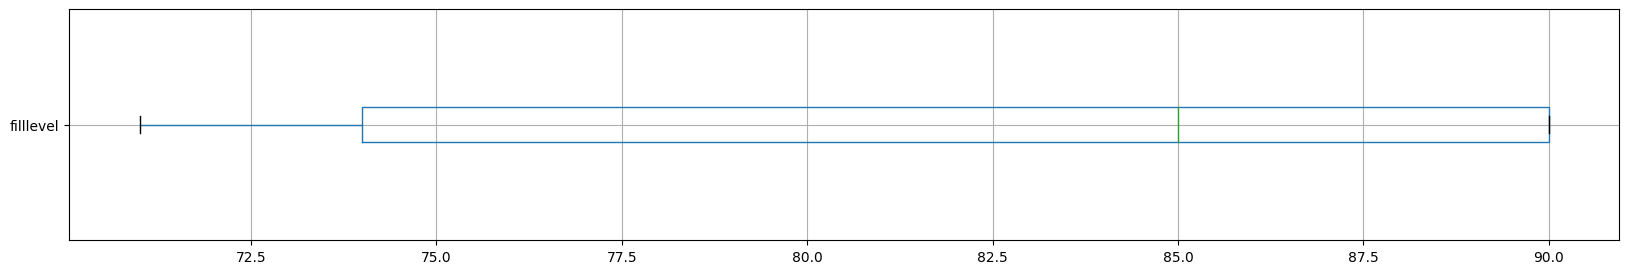

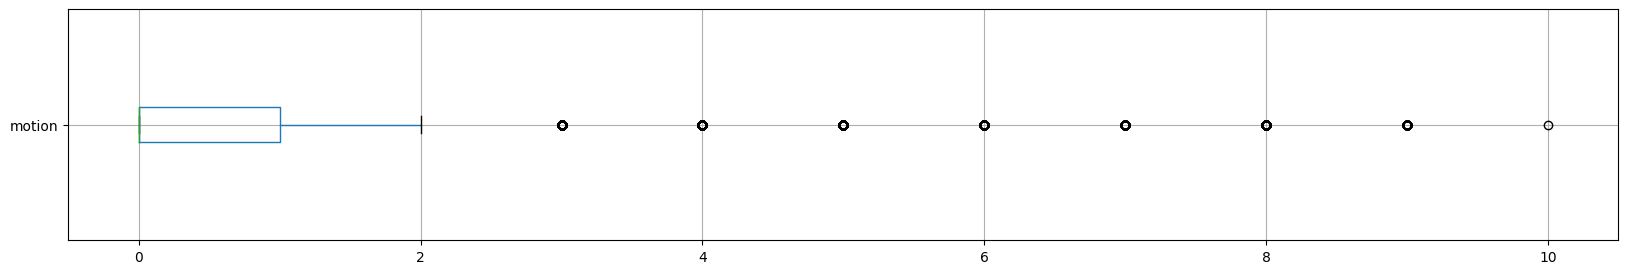

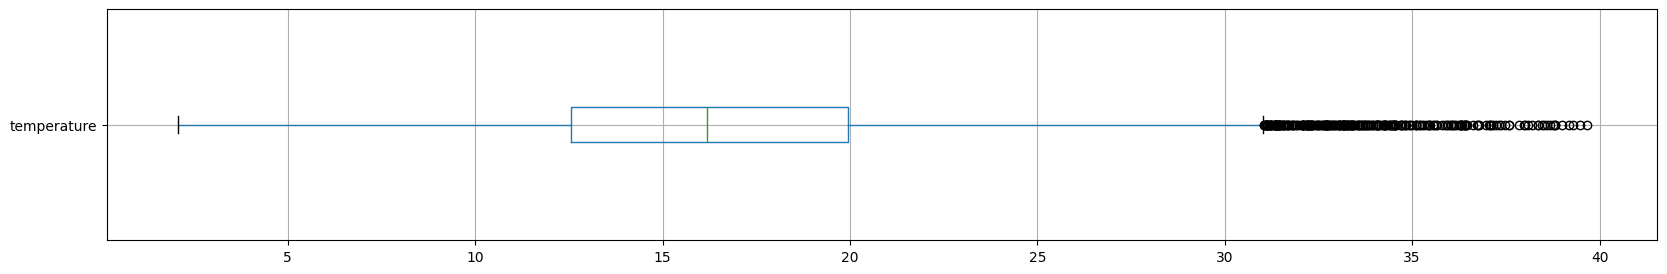

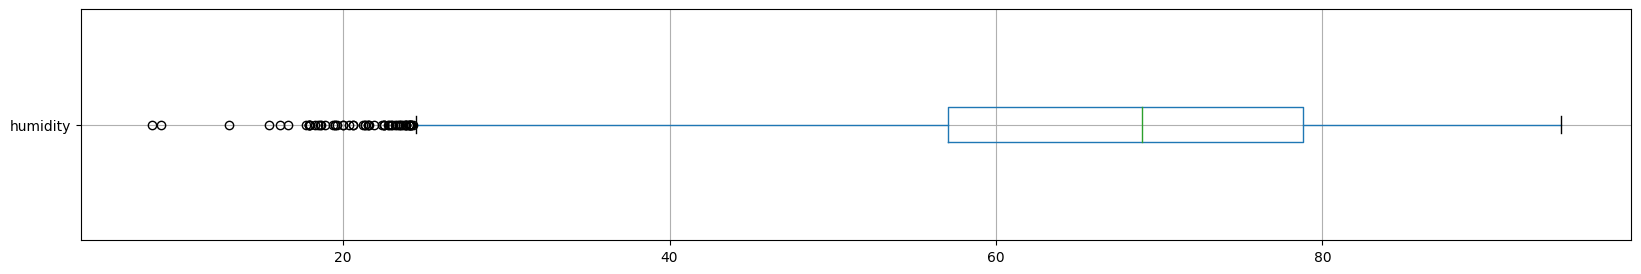

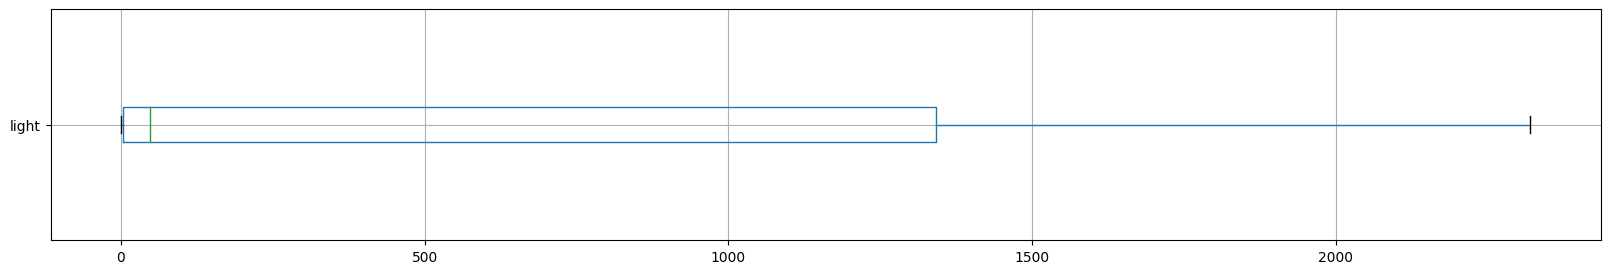

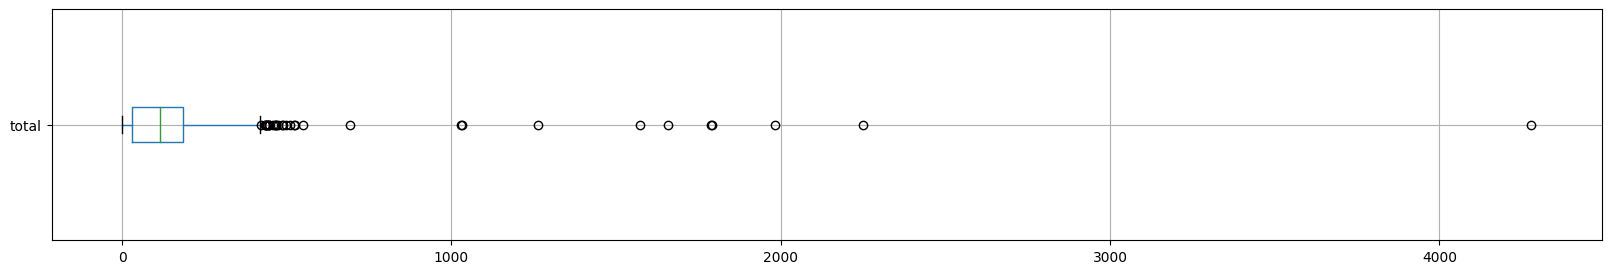

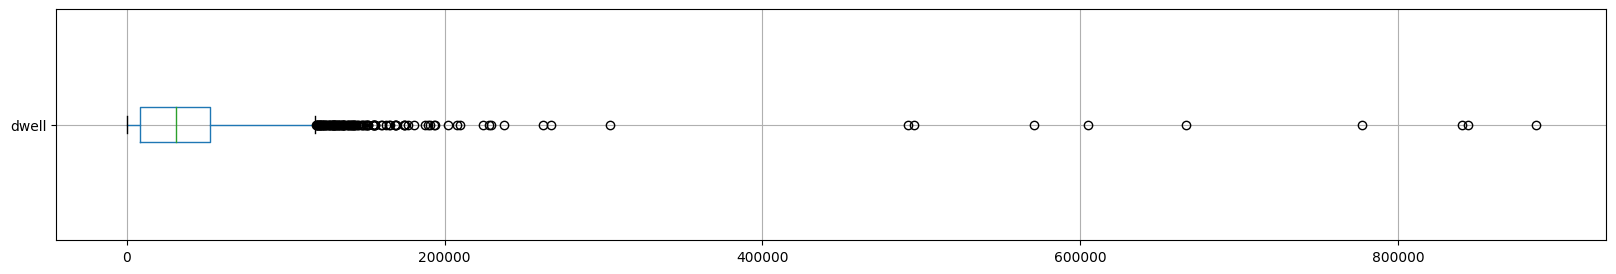

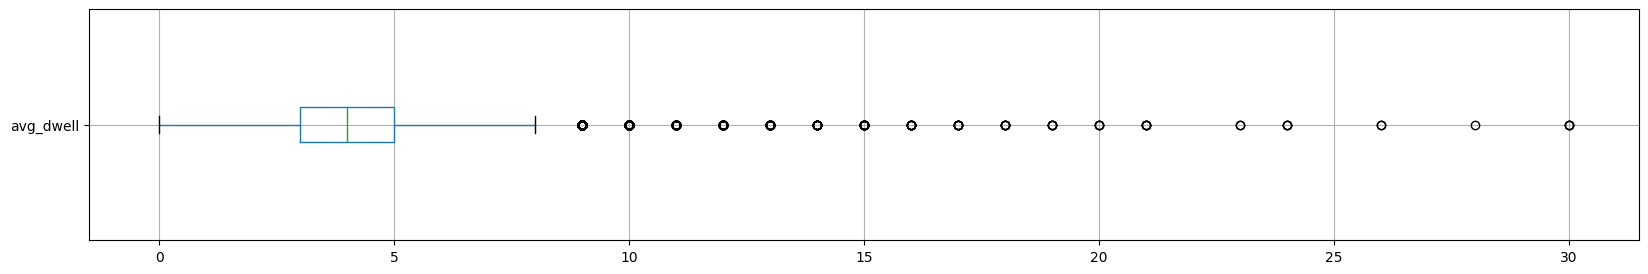

In [19]:
# Use box plots to check for any unexpected values in data

# Iterate over columns and create a horizontal box plot for each one
for column in merged_dataframe:
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure()
    merged_dataframe.boxplot([column], vert=False)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

The box plots show that there are outliers in most of the columns of data. As there are outliers in total, they would be expected in dwell and total_dwell, as big events do not occur often. Weather outliers will also be kept as these numbers are seen to make sense in their datasets. 

### FEATURE CORRELATION

In [20]:
# Drop rows with na values
merged_dataframe = merged_dataframe.dropna(axis=0, how='any')
# Add index column
merged_dataframe = merged_dataframe.reset_index()

Scatterplots are used to identify if there are relationshsips between each varaible and time.

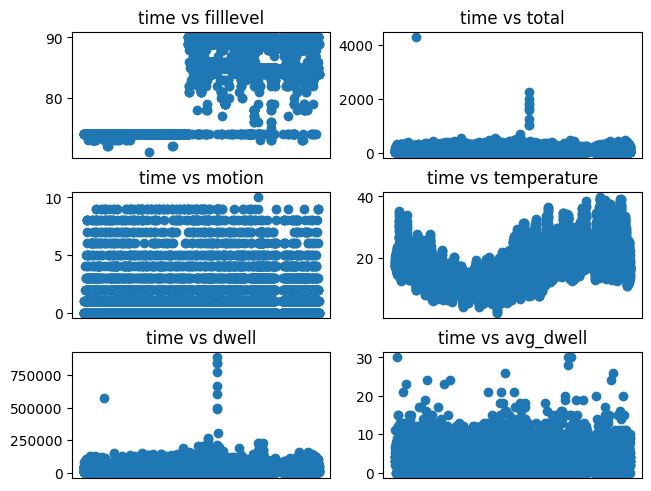

In [21]:
# Create scatter plots of datetime vs all other variables
fig, ax = plt.subplots(3, 2,constrained_layout = True)
# Create a plot of time vs filllevel
plt.subplot(3,2,1)
plt.scatter(merged_dataframe['date_time'], merged_dataframe['filllevel'])
plt.title("time vs filllevel")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs total
plt.subplot(3,2,2)
plt.scatter(merged_dataframe['date_time'],merged_dataframe['total'])
plt.title("time vs total")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs motion
plt.subplot(3,2,3)
plt.scatter(merged_dataframe['date_time'],merged_dataframe['motion'])
plt.title("time vs motion")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs temperature
plt.subplot(3,2,4)
plt.scatter(merged_dataframe['date_time'], merged_dataframe['temperature'])
plt.title("time vs temperature")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs dwell
plt.subplot(3,2,5)
plt.scatter(merged_dataframe['date_time'],merged_dataframe['dwell'])
plt.title("time vs dwell")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs avg_dwell
plt.subplot(3,2,6)
plt.scatter(merged_dataframe['date_time'], merged_dataframe['avg_dwell'])
plt.title("time vs avg_dwell")
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


From the scatterplots against time, the relationships evident are that of time against average dwelling and time against motion. All other variable pairs have no clear pattern. Pairplots will be used to investigate the relationship between all other variables.

A Pairs plot will be used to visualise the relationships between numeric variables.

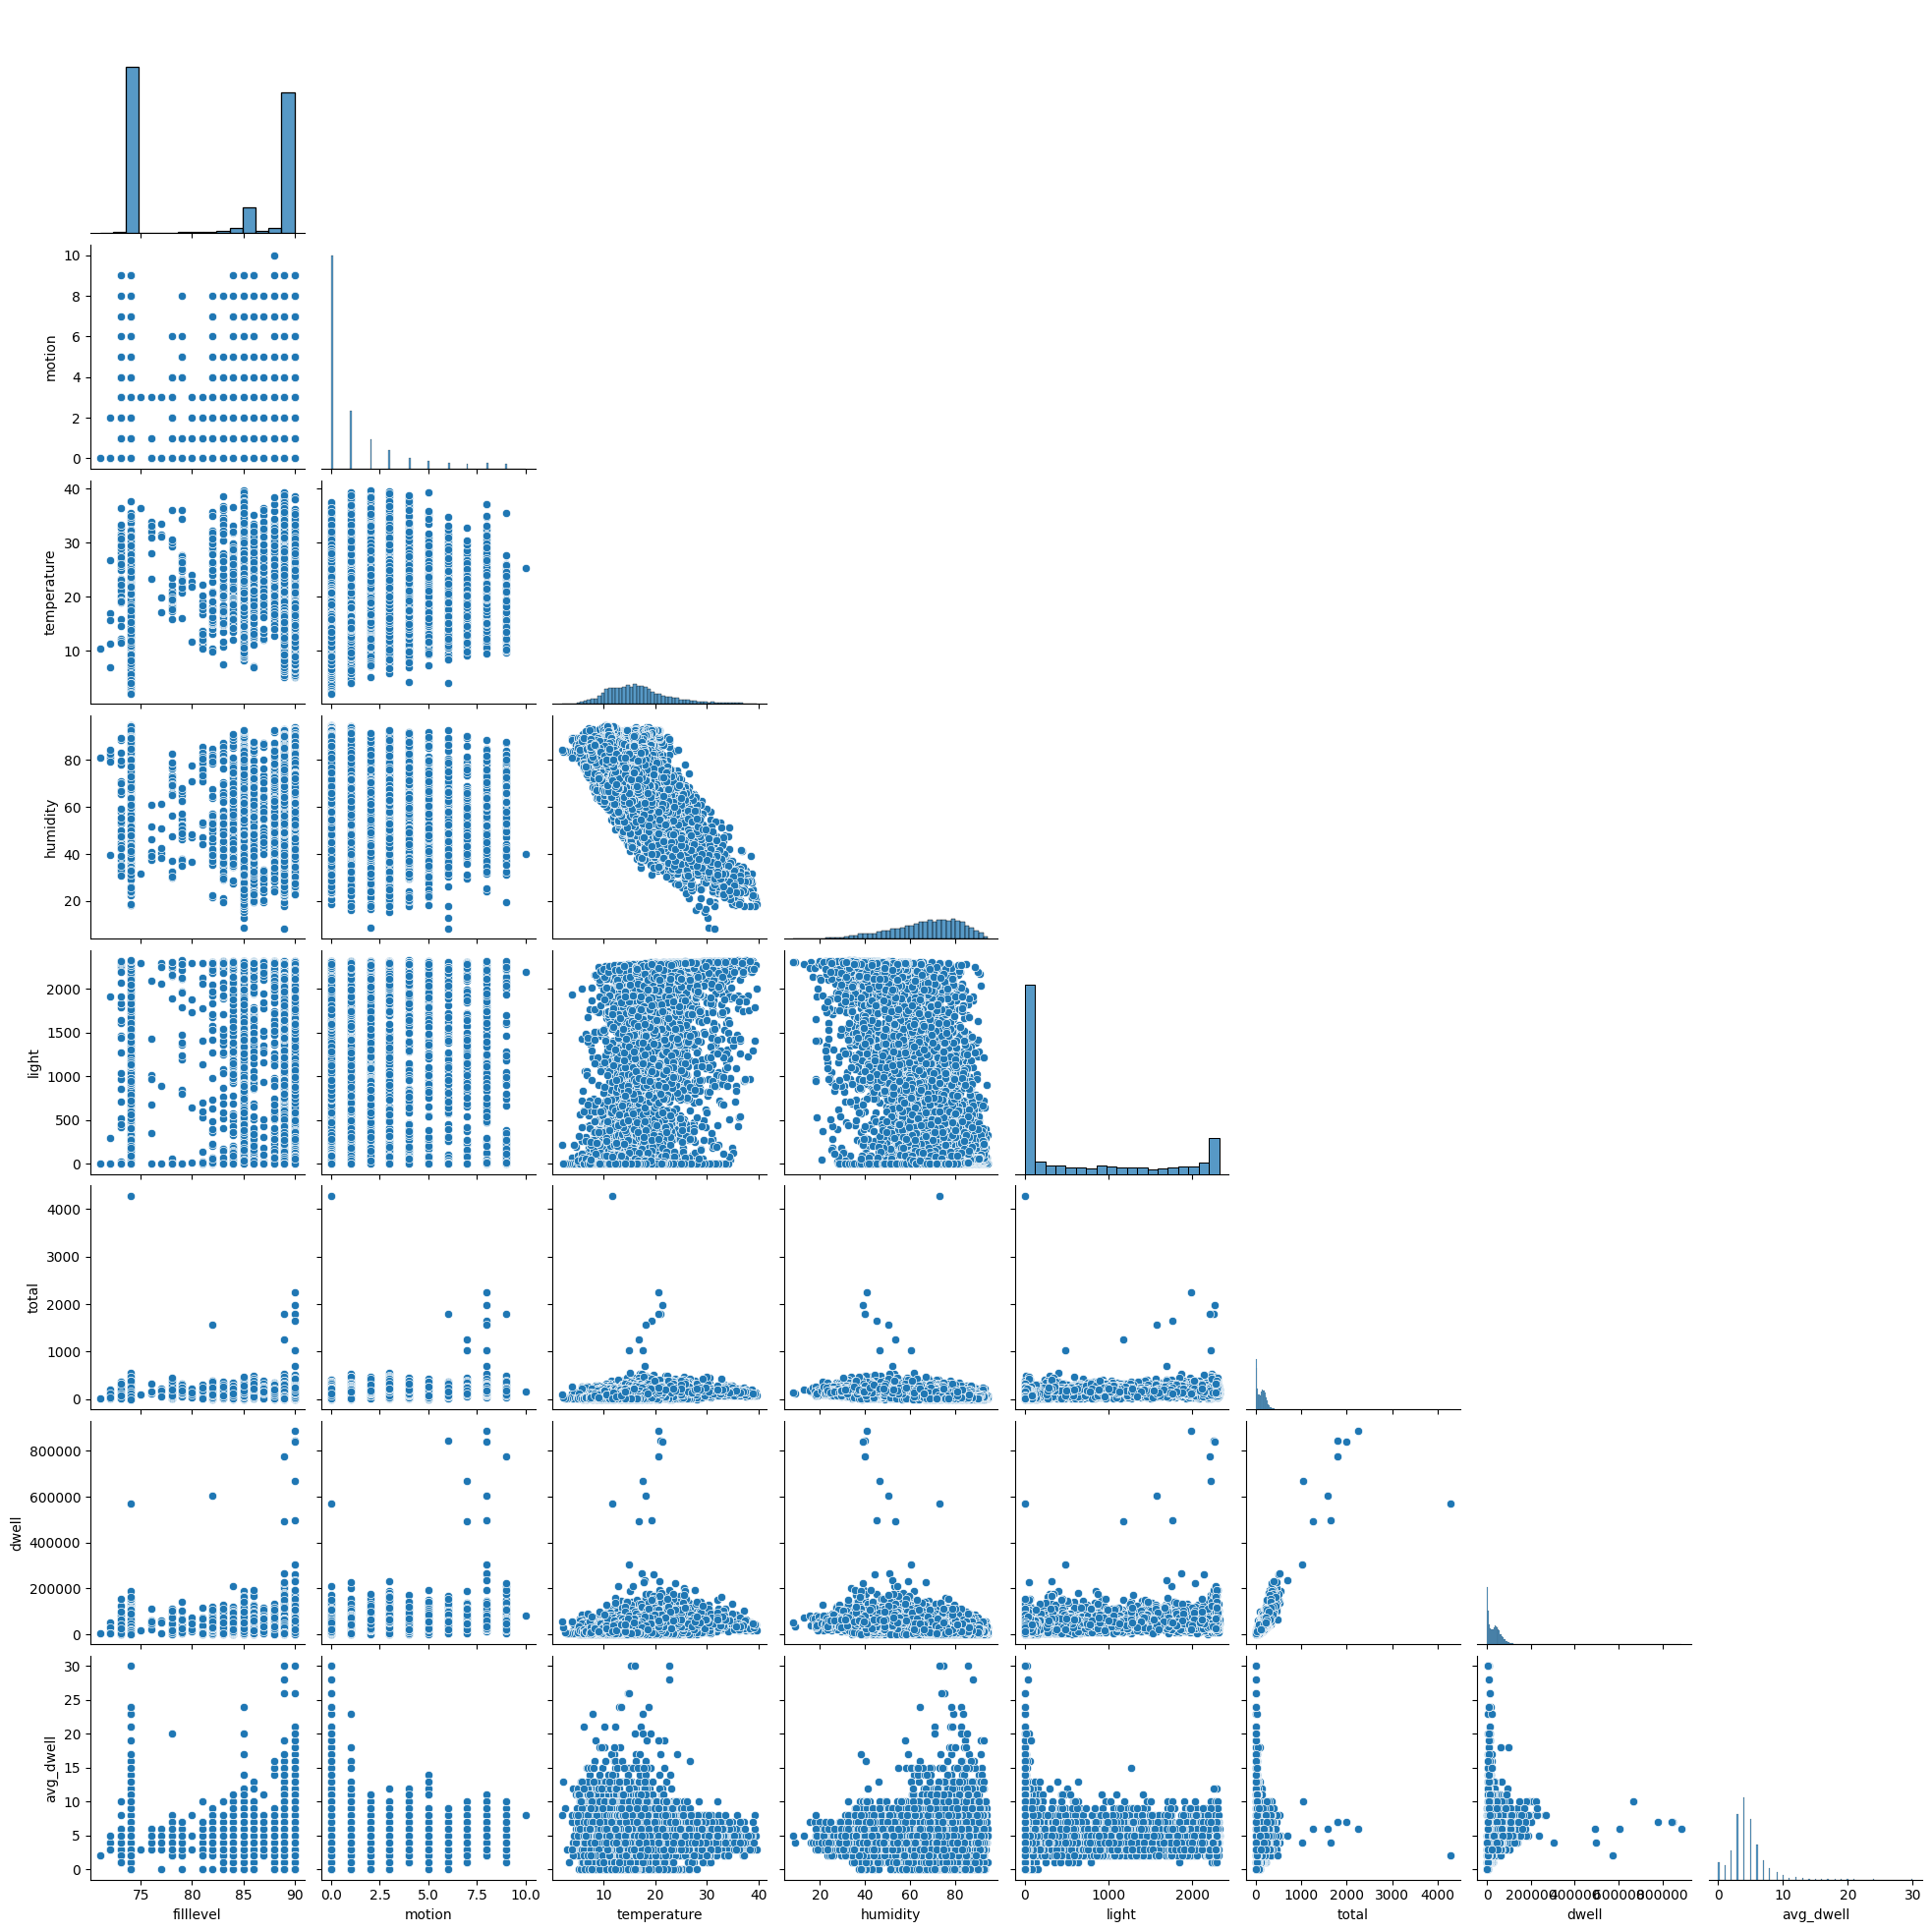

In [23]:
# Create a pairsplot to look at relationships between other variables
merged_dataframe.reset_index(drop=True, inplace=True)
sns.pairplot(merged_dataframe, corner=True)
plt.show()

The pairs plot shows a relationship between numerical variables. Temperature and humidity have the stronggest linear reationship, followed by light with temperature and light with humidity. Total and dwell also have a strong linear relationship. The goal of this task is to find relationships between sensor data and bin fill levels. From the scatterplots shown in the pairsplot, there is no strong relationship between bin fill levels and any single other varaible. It would be uesful to quantify the relationships shown in the pairplot, which will be done using a correlation heatmap.

Int the correlation heatmap, Pearson correlation is used to determine extent of linear relationship between each pair of variables. This is because several of the variables are seen to have a strong linear relationship and this needs to be measured.

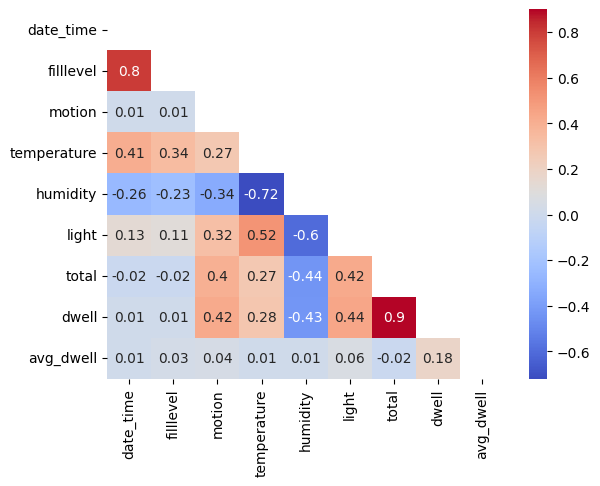

In [24]:
# Calculate correlation heatmap for all columns
matrix = merged_dataframe.corr(method = 'pearson').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(matrix, annot=True, cmap=color, mask=mask)

plt.show()

The correlation heatmap shows the extent of the linear relationship between variables. The strongest linear relaionship is shown to be between total and dwell data. Humidity and temperature also have a strong linear correlation, followed by light and temperature. In this investigation the focus is on the relationship between fill level and other variables. The highest linear relationship including bin fill level is between fill level and time, at 0.8 positive linear relationship. Next is temperature and bin fill level, with has a medium negative linear correlation of 0.34, followed by other weather related variables. Motion, dwelling and total are seen to have weak negative linear relationships with bin fill level. Of note, bin fill level and total are seen to have a very weak negative relationship.

As few variables exhibit a strong linear relationship with bin fill level in the heatmap or pairplot, the existance of non-linear relationships should also be measured. The Distance Correlation uses the dcor package to help capture the extent of non-linear correlation between variables and bin fill level. As bin fill level is the main variable of interest, measurements of each varaibles correlation to fill level will be calculated. It is important to note that date time is not supported in the distance calculation function.

In [25]:
# Calculate distance correlation between numerical variables and bin fill level (Datetime not supported)
print("filllevel and total =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['total']))
print("filllevel and dwell =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['dwell']))
print("filllevel and avg_dwell =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['avg_dwell']))
print("filllevel and motion =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['motion']))
print("filllevel and temperature =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['temperature']))
print("filllevel and humidity =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['humidity']))
print("fillevel and light =" , dcor.distance_correlation(merged_dataframe['filllevel'],merged_dataframe['light']))


filllevel and total = 0.04737522769314353
filllevel and dwell = 0.041870152242495275
filllevel and avg_dwell = 0.041818008373482825
filllevel and motion = 0.04396768938162847
filllevel and temperature = 0.3672145472802947
filllevel and humidity = 0.23947464320190792
fillevel and light = 0.12140752151312754


The strongest non-linear correlations measured remain between bin fill level and weather variables of temperature, humidity and light. As with the linear correlation measurement, the distance correlation also finds little non-linear relationships between total, dwell, motion and the variable of interest, bin fill level.

### FEATURE ENGINEERING

An important role of exploratory data analysis is identifying feature correlation. The results of this correlation is used in the selection of features on which to carry out modelling processes. Correlated features need to be removed prior to predictive modelling taking place. This can be done in several ways, including PCA and domain knowledge. 

PCA feature selection uses a mathematic transformation to project the variables to a new co-ordinate system <a href="#fn-4">[4]</a>. This apporach selects the most important attributes that best explain the variance of the dependent variable, removng correlation between features. However, the components no longer represent individual data (temperature, light, humidity) etc, insetad become a combination which is not clearly identfiable. This means that it would be much harder to explain how the modelling works and to make future predictions. For this reason, the use of PCA is not appropriate for this use case.

Domain knowledge is determined as the best method for feature selection in this use case. As the dataset is small, expected relationships from domain knowledge are not all shown in the data. This means that feature selection algorithms may disreguard data which is influential to bin fill levels in the real world. This also allows data that has obvious correlation to be removed from prior to predictions.

The features choosen to be removed are light and humidity, due to their strong linear relationships with temperature. Dwell wil also be removed due to the strong linear relationship with total. As there are gaps in the time data, as well as an obvious point of time in which the pattern of bin fill level changes shown on the scatterplot of time vs bin fill level, the time variable will also be removed from the dataset prior to predictive modelling. In addiiton, average dwell will also be removed as it is repetiition of information from the dwell data.

In [28]:
# Select required features for modelling
model_dataframe = merged_dataframe[['filllevel','motion','temperature','total']]
model_dataframe.head(3)

,filllevel,motion,temperature,total
0,74.0,0.0,20.446154,177.0
1,74.0,0.0,19.538462,137.0
2,74.0,0.0,19.380000,77.0


Feature transformation is also required prior to data modelling. As some data columns have very large values and others very small, these is a need to standardise the data. Z-score scaling is used as some data columns have small outliers (which make sense within their datasets). This ensures all features have a mean of 0 and a standard deviation of 1. This also means that when used in modelling the values of one feature will not skew the model results. 

In [29]:
# Apply z-score standardisation to all columns
model_dataframe_standard = model_dataframe.apply(zscore)
model_dataframe_standard.head(3)

,filllevel,motion,temperature,total
0,-1.025681,-0.567326,0.638234,0.497087
1,-1.025681,-0.567326,0.483119,0.140741
2,-1.025681,-0.567326,0.456039,-0.393778


### PREDICTIVE MODELLING

The main issue in predictive modelling for this use case is the small dataset size. To solve the problem of little data, research was completed to try to find open datasets conatining smart bin fill level data, stage use data, pedestrian counts and temperature but no datasets of corresponding locations open source could be found. The Australian Government data portal currenlty holds data on smart bins for Wyndham and Mildura areas. Pedestrian data is availible for Liverpoool, Ballarat, City of Casey, City of Sydney and Greater Geelong. Stage use data could not be found at any locations. As it is evident that there is no overlap between these datasets, additional data cannot be found within Australia. Kaggle was also searched, again reporting no appropriate international datasets. As it is assumed over time that the datasets used in this use case will increase as sensors as still in place, predictive modelling will become more accurate as data sets increase.

A regresion algorithm will be used to predict bin fill levels from the prepared dataset. Regression is choosen as it makes predictions on continuos variables with known measurements of the dependent variable, as in the case of bin fill levels. Both linear and polynomial regression will be applied to the data to compare results. Linear regression assumes an underlying linear relationship between the features of interest and bin fill level, while polynomial assumes a non-linear relationship.

First, a function will be created to calculate accuracy. Data will then be split into a test-train split, with 30% of data held as the test set and 70% of data used to train the model.

In [33]:
# Make function to analyse accuracy of predictions
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = round(correct_predictions/len(y_true)*100,2)
    print(f"The accuracy of this model is {accuracy}%")

In [34]:
# Set the x and y variables. Drop date_time as it is not supported by linear or random forest
X = model_dataframe_standard.drop(["filllevel"], axis=1)
y = model_dataframe_standard["filllevel"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

PREDICTIVE MODEL - Linear Regression

The importance of feature motion is -5.09%.
The importance of feature temperature is 37.75%.
The importance of feature total is -8.89%.


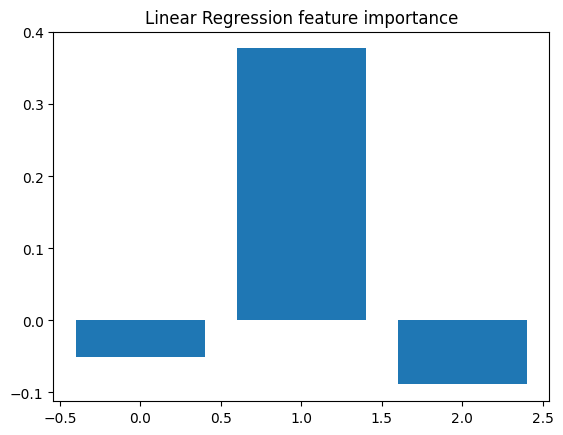

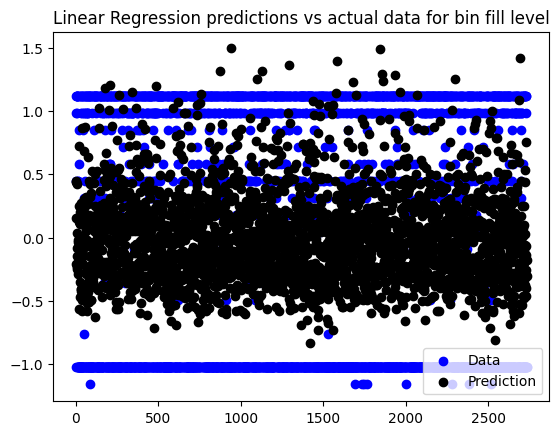

The accuracy of this model is 0.0%
R-squared value for Linear Regression is 0.13288874578621734


In [32]:
# Initiate Linear Regression
lr_model = LinearRegression()

# Train model on training data
lr_model.fit(X_train, y_train)

# Report on the importance of each feature used in the analysis
lr_importance = lr_model.coef_
columns = X.columns
i = 0
while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(lr_importance[i]*100,2)}%.")
    i += 1

# plot feature importance
plt.bar([x for x in range(len(lr_importance))], lr_importance)
plt.title("Linear Regression feature importance")
plt.show()

# Make predictions of test data using the model
lr_predictions = lr_model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue',label='Data')
plt.scatter(range(len(lr_predictions)), lr_predictions, color='black',label='Prediction')
plt.title("Linear Regression predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, lr_predictions)

# Calculate the r2 value for the model
r2_score = lr_model.score(X, y)
print(f"R-squared value for Linear Regression is {r2_score}")

The linear Regresison model aims to predict the values in the bin fill level column from the linear relationship with the all other numerical variables; motion, temperature, humidity, light, total, dwell and avg_dwell. The table and bar graph report the importance of each feature in the calculation of bin fill level. The most influential variable is temperature, at 44.41%, followed by motion at -22.08% and avg_dwell at 4.59%. All other variables contribute less than 2% to the Linear Regression model.
Model performance is evaluated using a scatterplot as well as accuracy and r-squared calculations. The scatterplot compares the predictions from the model with the actual values from the dataset. From this plot it is seen that the Linear Regression analysis has a tendency to return average bin fill levels, with most predictions around the mean of 1.
The accuracy of the model is calculated by dividing the total number of times the prediction exactly matches the data value in the table and dividing by the total number of predictions. The Linear Regression model made 0 accurate predictions. The r-squared value is also low, at 0.13, meaning that the Linear Regression model explains very little of the variation in the bin fill level variable around its mean.


Predictive model - Polynomial Regression

The importance of feature motion is 4.28%.
The importance of feature temperature is 22.13%.
The importance of feature humidity is 17.83%.
The importance of feature light is 21.92%.
The importance of feature total is 13.23%.
The importance of feature dwell is 14.07%.
The importance of feature avg_dwell is 6.55%.


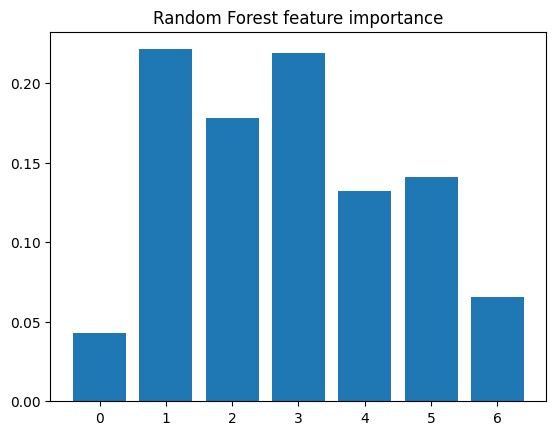

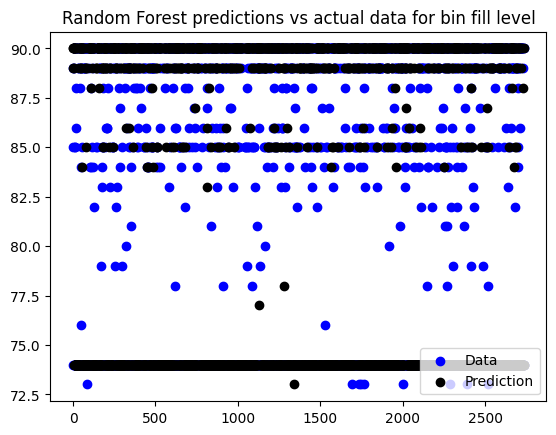

The accuracy of this model is 59.38%
R-squared value for Random Forest is 0.8781263712154453


In [ ]:
# Set the x and y variables. Drop date_time as it is not supported by linear or random forest
X = fmd_p.drop(["filllevel_y",'date_time',"filllevel_x"], axis=1)
y = fmd_p["filllevel_x"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate the Random Forest classifier
estimators = 88
rf_model = RandomForestClassifier(n_estimators=estimators, random_state=44)

# Train model on training data
rf_model.fit(X_train, y_train)

# Report on the importance of each feature used in the analysis
rf_importance = rf_model.feature_importances_
columns = X.columns
i = 0
while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(rf_importance[i]*100,2)}%.")
    i += 1

# plot feature importance
plt.bar([x for x in range(len(rf_importance))], rf_importance)
plt.title("Random Forest feature importance")
plt.show()

# Make predictions of test data using the model
rf_predictions = rf_model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(rf_predictions)), rf_predictions, color='black',label='Prediction')
plt.title("Random Forest predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, rf_predictions)

# Calculate the r2 value for the model
r2_score = rf_model.score(X, y)
print(f"R-squared value for Random Forest is {r2_score}")

Random Forest model uses an ensemble of decision trees to predict the values in the bin fill level column using non-linear classification. As with the linear regression model, all other numerical variables are used to train the model; motion, temperature, humidity, light, total, dwell and avg_dwell. The table and bar graph report the importance of each feature in the calculation of bin fill level. Like Linear Regression, the most influential variable is temperature (22.13%), closely followed by the other environmental variables (humidity at 17.8% and light at 21.9%). Dwell and total follow contributing a significant 14% and 13% respectively. Motion and avg_dwell contribute less than 7% each. 
Model performance is again evaluated using a scatterplot as well as accuracy and r-squared calculations. The scatterplot shows a tendency for Random Forest to also return high bin fill levels, however it returns several low values as well.
The accuracy of the model is above 59%, meaning that about half the time it predicts the exact value from the dataset. The r-squared value is also high, above 0.87, meaning that the Random Forest model explains most of the variation in the bin fill level variable around its mean. As well as demonstrating good model performance, the benefit of using this model for predictions is that Random Forest is less likely to overfit data even with smaller datasets.

#### FINDINGS OF ANALYSIS

The findings of this investigation into the variables effecting bin fill level at Argyle Square are inconclusive. It was expected that the total number of people would impact the bin fill level. However, pearson correlation found a very weak negaive association, while the distance calcution also found a very weak correlation. Linear regression identified negative feature imporance for total to bin fill level and additionally random forest classification rated total as of small importance in calculating bin fill level from data provided. The results from linear correlation and linear regression suggest a negative relationship between total and bin fill level, i.e, that the more people at a location the less rubbish in the bin. Using real world understanding we know that this is not possible. This suggests that the data set is not yet large enough to be used in predictive anaylsis. This is supported by the size of the dataset; because the data set is so small and contains data from only one year (after all data cleaning and merging has taken place) there is not enough data to build an accurate predictive model from. Over time, as the data sets used in this use case grow, this use case could be used as a basis for creating a predicitive model.

##### References

<fn id="fn-1">[1]</fn> Ecube Labs (2016) [Overflowing garbage bins: 5 impacts on health and environment, and how to prevent.](https://www.ecubelabs.com/overflowing-garbage-bins-5-impacts-on-health-and-environment-and-how-to-prevent/). Ecube Labs, North America & Asia. 

<fn id="fn-2">[2]</fn> Ferrer, J & Alba, E (2019) [BIN-CT: Urban waste collection based on predicting the container fill level](https://www.sciencedirect.com/science/article/abs/pii/S0303264718301333). BioSystems, Vol 186. England. 

<fn id="fn-3">[3]</fn> Participate Melbourne (2022) [Data in the Park - Argyle Square.](https://participate.melbourne.vic.gov.au/emerging-tech-testbed/data-park). City of Melbourne Council, Australia.

<fn id="fn-4">[4]</fn> Geeks for Geeks (2023) [What is Feature Engineering?](https://www.geeksforgeeks.org/what-is-feature-engineering/). Geeks for Geeks.